In [1]:
import sys
print(sys.version)

import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
import pickle

3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:24:38) 
[Clang 12.0.1 ]


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1
workers

7

In [70]:
df = pd.read_pickle("cluster.pkl")

In [2]:
pd.__version__

'1.4.2'

In [71]:
df = df[df["cluster"]==0].reset_index()

In [85]:
df

,index,date,language,title,text,text_clean,cluster
0,0,2022-01-06,english,No dea...,CHICAG...,chicag...,0
1,1,2022-01-06,english,No dea...,CHICAG...,chicag...,0
2,2,2022-01-06,english,Watch ...,Chicag...,chicag...,0
3,3,2022-01-06,english,Trump’...,Wise o...,wise o...,0
4,4,2022-01-06,english,Family...,The ne...,the ne...,0
...,...,...,...,...,...,...,...
181866,200114,2022-03-05,english,Chicag...,Author...,author...,0
181867,200115,2022-03-05,english,Loyola...,The No...,the no...,0
181868,200116,2022-03-05,english,DraftK...,Rememb...,rememb...,0
181869,200117,2022-03-05,english,Sidney...,[Block...,...,0


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = df['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

In [8]:
stop_words = stopwords.words('english')
data_tokens_nostops = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_tokens]

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_tokens_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
import pickle
pickle.dump(data_lemmatized, open("lematized.pkl", 'wb'))

In [4]:
data_lemmatized = pickle.load(open("lematized.pkl", 'rb'))

In [5]:
dictionary = corpora.Dictionary(data_lemmatized)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

### 10 Topics baseline

In [13]:
%%time

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   alpha='symmetric',
                   eta='auto',
                   workers=workers)

CPU times: user 1min 30s, sys: 41.1 s, total: 2min 11s
Wall time: 2min 22s


In [14]:
pprint(lda_model.print_topics())
doc_lda = lda_model[doc_term_matrix]

[(0,
  '0.018*"lawyer" + 0.010*"court" + 0.009*"get" + 0.008*"also" + '
  '0.008*"attorney" + 0.007*"family" + 0.007*"well" + 0.007*"accident" + '
  '0.007*"law" + 0.006*"time"'),
 (1,
  '0.027*"school" + 0.024*"say" + 0.014*"student" + 0.014*"covid" + '
  '0.011*"district" + 0.009*"state" + 0.008*"case" + 0.008*"teacher" + '
  '0.007*"day" + 0.007*"week"'),
 (2,
  '0.029*"say" + 0.013*"police" + 0.012*"year" + 0.007*"officer" + '
  '0.006*"charge" + 0.006*"old" + 0.006*"people" + 0.006*"state" + 0.006*"man" '
  '+ 0.006*"shoot"'),
 (3,
  '0.025*"game" + 0.017*"point" + 0.015*"season" + 0.014*"team" + 0.013*"bear" '
  '+ 0.010*"play" + 0.009*"first" + 0.009*"last" + 0.009*"bull" + '
  '0.008*"coach"'),
 (4,
  '0.021*"roof" + 0.014*"also" + 0.011*"well" + 0.010*"roofing" + 0.008*"make" '
  '+ 0.008*"pizza" + 0.007*"get" + 0.007*"cover" + 0.006*"use" + '
  '0.006*"repair"'),
 (5,
  '0.007*"service" + 0.006*"business" + 0.006*"company" + 0.006*"include" + '
  '0.006*"year" + 0.005*"com" +

In [15]:
%%time

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5482613031446424
CPU times: user 10.9 s, sys: 3.55 s, total: 14.4 s
Wall time: 1min 35s


### Tune

In [17]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [18]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [19]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 10
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_csv('lda_tuning_results.csv', index=False)

LDA will execute 11 iterations
Completed model based on 10 LDA topics. Finished 9.1% of LDA runs
Execution time to calculate for topic 10: 0hour:4min:8sec
Completed model based on 11 LDA topics. Finished 18.2% of LDA runs
Execution time to calculate for topic 11: 0hour:4min:40sec
Completed model based on 12 LDA topics. Finished 27.3% of LDA runs
Execution time to calculate for topic 12: 0hour:5min:3sec
Completed model based on 13 LDA topics. Finished 36.4% of LDA runs
Execution time to calculate for topic 13: 0hour:5min:8sec
Completed model based on 14 LDA topics. Finished 45.5% of LDA runs
Execution time to calculate for topic 14: 0hour:6min:5sec
Completed model based on 15 LDA topics. Finished 54.5% of LDA runs
Execution time to calculate for topic 15: 0hour:7min:15sec
Completed model based on 16 LDA topics. Finished 63.6% of LDA runs
Execution time to calculate for topic 16: 0hour:6min:0sec
Completed model based on 17 LDA topics. Finished 72.7% of LDA runs
Execution time to calculat

In [9]:
lda_tuning1 = pd.read_csv('lda_tuning_results.csv')
lda_tuning = pd.read_csv('lda_tuning_results_21.csv')

In [10]:
lda_all = pd.concat([lda_tuning1,lda_tuning],ignore_index=True)

In [11]:
lda_all.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
11,21,asymmetric,auto,0.573626
10,20,asymmetric,auto,0.572596
12,22,asymmetric,auto,0.571798
6,16,asymmetric,auto,0.570890
9,19,asymmetric,auto,0.570802
15,25,asymmetric,auto,0.569157
5,15,asymmetric,auto,0.563674
3,13,asymmetric,auto,0.561593
13,23,asymmetric,auto,0.560258
14,24,asymmetric,auto,0.556557


In [12]:
lda_all.sort_values(by=['Coherence']).head(10)

,Topics,Alpha,Beta,Coherence
2,12,asymmetric,auto,0.529635
1,11,asymmetric,auto,0.532306
8,18,asymmetric,auto,0.539952
4,14,asymmetric,auto,0.547520
7,17,asymmetric,auto,0.549706
0,10,asymmetric,auto,0.549915
14,24,asymmetric,auto,0.556557
13,23,asymmetric,auto,0.560258
3,13,asymmetric,auto,0.561593
5,15,asymmetric,auto,0.563674


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

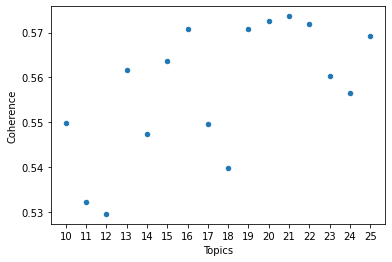

In [13]:
lda_all.plot(x ='Topics', y='Coherence', kind = 'scatter', xticks=range(10,26))

<AxesSubplot:xlabel='Topics'>

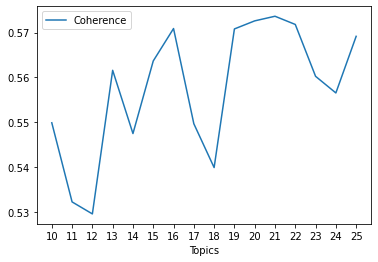

In [14]:
lda_all.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(10,26))

## Best Model

In [15]:
lda_tuning_best = lda_all.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 21, Alpha: asymmetric, Beta: auto


In [18]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.571159716235502
CPU times: user 3min 4s, sys: 1min 48s, total: 4min 53s
Wall time: 6min 57s


In [19]:
pickle.dump(tuned_lda_model, open('lda_21.pkl', 'wb'))

In [6]:
import pickle
tuned_lda_model = pickle.load(open('lda_21.pkl', 'rb'))

In [7]:
all_topics = []
topics = tuned_lda_model.show_topics(formatted=False,num_words=20,num_topics = 21)
for index, topic in topics:
    all_topics.append([w[0] for w in topic])
topics_df = pd.DataFrame(all_topics)
topics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,lawyer,accident,get,insurance,truck,injury,know,well,law,time,personal,attorney,company,make,content,legal,case,use,firm,work
1,school,say,student,district,teacher,covid,mask,union,announce,class,day,public,ago,test,parent,remote,week,child,staff,safety
2,say,police,year,officer,man,shoot,old,charge,news,report,fire,people,take,accord,find,kill,arrest,city,murder,car
3,game,bull,team,point,season,first,play,win,second,get,go,last,lead,make,score,big,player,good,time,basketball
4,roof,roofing,also,well,repair,cover,make,need,get,company,actually,system,dumpster,service,water,work,door,use,new,shingle
5,service,work,community,business,include,experience,company,provide,year,program,new,com,job,project,team,support,opportunity,help,build,information
6,say,go,get,see,time,make,show,season,year,know,come,take,good,think,want,first,run,day,thing,start
7,say,russian,ukrainian,year,country,also,company,use,energy,people,plant,ukraine,high,oil,make,report,supply,new,price,world
8,share,company,stock,quarter,rating,work,tool,price,own,buy,report,product,average,ratio,research,get,additional,last,dividend,sell
9,document,social,_,important,ad,color,text,margin,icon,function,display,leave,bottom,block,post,window,right,body,tdi,true


In [8]:
for idx, topic in tuned_lda_model.show_topics(formatted=False, num_words= 10,num_topics = 21):
    print('Topic: {} - Words: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 - Words: lawyer|accident|get|insurance|truck|injury|know|well|law|time
Topic: 1 - Words: school|say|student|district|teacher|covid|mask|union|announce|class
Topic: 2 - Words: say|police|year|officer|man|shoot|old|charge|news|report
Topic: 3 - Words: game|bull|team|point|season|first|play|win|second|get
Topic: 4 - Words: roof|roofing|also|well|repair|cover|make|need|get|company
Topic: 5 - Words: service|work|community|business|include|experience|company|provide|year|program
Topic: 6 - Words: say|go|get|see|time|make|show|season|year|know
Topic: 7 - Words: say|russian|ukrainian|year|country|also|company|use|energy|people
Topic: 8 - Words: share|company|stock|quarter|rating|work|tool|price|own|buy
Topic: 9 - Words: document|social|_|important|ad|color|text|margin|icon|function
Topic: 10 - Words: loan|get|credit|check|cash|make|money|offer|pay|day
Topic: 11 - Words: covid|case|rate|state|day|new|high|week|say|price
Topic: 12 - Words: state|say|year|tax|law|federal|make|also|includ

In [10]:
for idx, topic in tuned_lda_model.show_topics(formatted=False, num_words= 5,num_topics = 21):
    print('Topic {} - {}'.format(idx, '|'.join( ["{:.3f} {}".format(w[1],w[0]) for w in topic])))

Topic 0 - 0.021 lawyer|0.013 accident|0.010 get|0.008 insurance|0.008 truck
Topic 1 - 0.047 school|0.027 say|0.024 student|0.019 district|0.014 teacher
Topic 2 - 0.031 say|0.020 police|0.014 year|0.011 officer|0.009 man
Topic 3 - 0.034 game|0.016 bull|0.016 team|0.015 point|0.013 season
Topic 4 - 0.032 roof|0.015 roofing|0.015 also|0.012 well|0.009 repair
Topic 5 - 0.008 service|0.008 work|0.007 community|0.007 business|0.007 include
Topic 6 - 0.014 say|0.013 go|0.012 get|0.008 see|0.007 time
Topic 7 - 0.023 say|0.006 russian|0.006 ukrainian|0.006 year|0.006 country
Topic 8 - 0.049 share|0.036 company|0.035 stock|0.027 quarter|0.024 rating
Topic 9 - 0.033 document|0.032 social|0.031 _|0.029 important|0.024 ad
Topic 10 - 0.014 loan|0.012 get|0.009 credit|0.009 check|0.007 cash
Topic 11 - 0.014 covid|0.014 case|0.010 rate|0.010 state|0.010 day
Topic 12 - 0.019 state|0.016 say|0.010 year|0.008 tax|0.007 law
Topic 13 - 0.036 com|0.022 https|0.011 use|0.009 website|0.009 download
Topic 14 -

In [11]:
all_topics = []
topics = tuned_lda_model.show_topics(formatted = False, num_words=10,num_topics = 21)
for index, topic in topics:
    word = [(w[0],"{:.2f}".format(w[1])) for w in topic]
    all_topics.append(word)
topics_df = pd.DataFrame(all_topics)
topics_df

,0,1,2,3,4,5,6,7,8,9
0,"(lawyer, 0.02)","(accident, 0.01)","(get, 0.01)","(insurance, 0.01)","(truck, 0.01)","(injury, 0.01)","(know, 0.01)","(well, 0.01)","(law, 0.01)","(time, 0.01)"
1,"(school, 0.05)","(say, 0.03)","(student, 0.02)","(district, 0.02)","(teacher, 0.01)","(covid, 0.01)","(mask, 0.01)","(union, 0.01)","(announce, 0.01)","(class, 0.01)"
2,"(say, 0.03)","(police, 0.02)","(year, 0.01)","(officer, 0.01)","(man, 0.01)","(shoot, 0.01)","(old, 0.01)","(charge, 0.01)","(news, 0.01)","(report, 0.01)"
3,"(game, 0.03)","(bull, 0.02)","(team, 0.02)","(point, 0.01)","(season, 0.01)","(first, 0.01)","(play, 0.01)","(win, 0.01)","(second, 0.01)","(get, 0.01)"
4,"(roof, 0.03)","(roofing, 0.01)","(also, 0.01)","(well, 0.01)","(repair, 0.01)","(cover, 0.01)","(make, 0.01)","(need, 0.01)","(get, 0.01)","(company, 0.01)"
5,"(service, 0.01)","(work, 0.01)","(community, 0.01)","(business, 0.01)","(include, 0.01)","(experience, 0.01)","(company, 0.01)","(provide, 0.01)","(year, 0.01)","(program, 0.01)"
6,"(say, 0.01)","(go, 0.01)","(get, 0.01)","(see, 0.01)","(time, 0.01)","(make, 0.01)","(show, 0.01)","(season, 0.01)","(year, 0.01)","(know, 0.01)"
7,"(say, 0.02)","(russian, 0.01)","(ukrainian, 0.01)","(year, 0.01)","(country, 0.01)","(also, 0.01)","(company, 0.00)","(use, 0.00)","(energy, 0.00)","(people, 0.00)"
8,"(share, 0.05)","(company, 0.04)","(stock, 0.04)","(quarter, 0.03)","(rating, 0.02)","(work, 0.02)","(tool, 0.02)","(price, 0.02)","(own, 0.01)","(buy, 0.01)"
9,"(document, 0.03)","(social, 0.03)","(_, 0.03)","(important, 0.03)","(ad, 0.02)","(color, 0.02)","(text, 0.02)","(margin, 0.02)","(icon, 0.01)","(function, 0.01)"


In [46]:
topics_df.to_csv("topics.csv")

In [12]:
pprint(tuned_lda_model.print_topics())

[(20,
  '0.029*"prize" + 0.027*"sponsor" + 0.026*"winner" + 0.024*"sweepstake" + '
  '0.014*"entrant" + 0.011*"travel" + 0.010*"rule" + 0.010*"event" + '
  '0.010*"award" + 0.009*"entry"'),
 (19,
  '0.029*"court" + 0.022*"family" + 0.022*"lawyer" + 0.020*"parent" + '
  '0.019*"divorce" + 0.018*"child" + 0.014*"attorney" + 0.014*"also" + '
  '0.014*"mom" + 0.012*"kid"'),
 (18,
  '0.018*"pizza" + 0.011*"also" + 0.010*"food" + 0.008*"style" + 0.008*"crust" '
  '+ 0.008*"make" + 0.007*"well" + 0.007*"restaurant" + 0.007*"good" + '
  '0.006*"thin"'),
 (17,
  '0.027*"alcohol" + 0.017*"also" + 0.015*"well" + 0.013*"treatment" + '
  '0.013*"drug" + 0.012*"new" + 0.012*"program" + 0.010*"beginning" + '
  '0.010*"step" + 0.010*"individual"'),
 (16,
  '0.030*"market" + 0.026*"bet" + 0.021*"bankruptcy" + 0.014*"sport" + '
  '0.011*"match" + 0.010*"live" + 0.010*"report" + 0.009*"spell" + '
  '0.009*"casino" + 0.008*"odd"'),
 (15,
  '0.084*"point" + 0.054*"game" + 0.029*"rebound" + 0.028*"average" 

In [44]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/Users/crystal/miniforge3/envs/tensorflow/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/crystal/miniforge3/envs/tensorflow/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/crystal/miniforge3/envs/tensorflow/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/crystal/miniforge3/envs/tensorflow/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/crystal/miniforge3/envs/tensorflow/lib/python3.9/site-packages/setupt

CPU times: user 2min 26s, sys: 1min 43s, total: 4min 10s
Wall time: 50.1 s


In [31]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 21
max_topics = 25
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_csv('lda_tuning_results_21.csv', index=False)

LDA will execute 5 iterations
Completed model based on 21 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 21: 0hour:6min:48sec
Completed model based on 22 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 22: 0hour:7min:18sec
Completed model based on 23 LDA topics. Finished 60.0% of LDA runs
Execution time to calculate for topic 23: 0hour:7min:49sec
Completed model based on 24 LDA topics. Finished 80.0% of LDA runs
Execution time to calculate for topic 24: 0hour:8min:48sec
Completed model based on 25 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 25: 0hour:9min:48sec
CPU times: user 18min 45s, sys: 10min 38s, total: 29min 24s
Wall time: 40min 30s


In [13]:
tuned_lda_model[doc_term_matrix[181870]]

[(6, 0.3601111),
 (7, 0.4521957),
 (10, 0.05652223),
 (15, 0.10355422),
 (19, 0.023265593)]

In [14]:
sorted(tuned_lda_model[doc_term_matrix[888]], key = lambda x: x[1], reverse=True)

[(5, 0.68982416),
 (11, 0.1406301),
 (17, 0.07651026),
 (13, 0.037108067),
 (19, 0.029985752),
 (4, 0.013998901)]

In [15]:
result = []
for row in doc_term_matrix:
    model = tuned_lda_model[row]
    model = sorted(model,key = lambda x: x[1], reverse=True)
    result.append(model)
topic_result = pd.DataFrame(result)

In [17]:
topic_result.shape

(181871, 21)

In [18]:
topic_result

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,"(1, 0.99801016)",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"(1, 0.9981448)",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"(6, 0.68928826)","(0, 0.21456297)","(17, 0.06122976)",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"(12, 0.45713565)","(1, 0.32274348)","(6, 0.07528731)","(13, 0.07374014)","(10, 0.047238603)","(18, 0.020676365)",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"(6, 0.5697616)","(2, 0.33611354)","(3, 0.08021704)",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181866,"(2, 0.8981696)","(0, 0.013380355)","(1, 0.01098114)",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
181867,"(15, 0.66274244)","(3, 0.17721134)","(14, 0.0833279)","(16, 0.07360722)",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
181868,"(10, 0.45125863)","(16, 0.33556783)","(13, 0.17699596)",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
181869,"(11, 0.9248463)","(18, 0.033205155)","(12, 0.028394243)",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [21]:
topic_3 = topic_result.iloc[:,0:3]
topic_3

,0,1,2
0,"(1, 0.99801016)",None,None
1,"(1, 0.9981448)",None,None
2,"(6, 0.6892894)","(0, 0.2145982)","(17, 0.06119341)"
3,"(12, 0.45713946)","(1, 0.32274434)","(6, 0.075292535)"
4,"(6, 0.5697575)","(2, 0.33612388)","(3, 0.0802108)"
...,...,...,...
181866,"(2, 0.8981696)","(0, 0.013380353)","(1, 0.010981139)"
181867,"(15, 0.66274667)","(3, 0.17719892)","(14, 0.083335176)"
181868,"(10, 0.45147094)","(16, 0.33560207)","(13, 0.17674942)"
181869,"(11, 0.9248083)","(18, 0.033204302)","(12, 0.02843308)"


In [72]:
t1 = pd.DataFrame(topic_3[0].to_list())
df["topic1"] = t1[0]
df["w1"] = t1[1]

In [74]:
temp = topic_3[1].dropna()
t2 = pd.DataFrame(temp.to_list(),index = temp.index)
t2 = t2.rename(columns={0: "topic2", 1: "w2"})

In [75]:
temp = topic_3[2].dropna()
t3 = pd.DataFrame(temp.to_list(),index = temp.index)
t3 = t3.rename(columns={0: "topic3", 1: "w3"})

In [76]:
df = df.join(t2)
df = df.join(t3)

In [77]:
pd.set_option('display.max_colwidth', 10)
df

,index,date,language,title,text,text_clean,cluster,topic1,w1,topic2,w2,topic3,w3
0,0,2022-01-06,english,No dea...,CHICAG...,chicag...,0,1,0.998010,NaN,NaN,NaN,NaN
1,1,2022-01-06,english,No dea...,CHICAG...,chicag...,0,1,0.998145,NaN,NaN,NaN,NaN
2,2,2022-01-06,english,Watch ...,Chicag...,chicag...,0,6,0.689289,0.0,0.214598,17.0,0.061193
3,3,2022-01-06,english,Trump’...,Wise o...,wise o...,0,12,0.457139,1.0,0.322744,6.0,0.075293
4,4,2022-01-06,english,Family...,The ne...,the ne...,0,6,0.569758,2.0,0.336124,3.0,0.080211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181866,200114,2022-03-05,english,Chicag...,Author...,author...,0,2,0.898170,0.0,0.013380,1.0,0.010981
181867,200115,2022-03-05,english,Loyola...,The No...,the no...,0,15,0.662747,3.0,0.177199,14.0,0.083335
181868,200116,2022-03-05,english,DraftK...,Rememb...,rememb...,0,10,0.451471,16.0,0.335602,13.0,0.176749
181869,200117,2022-03-05,english,Sidney...,[Block...,...,0,11,0.924808,18.0,0.033204,12.0,0.028433


In [82]:
pd.set_option('display.max_colwidth', 60)
temp = df[["title","text","topic1","w1","topic2","w2","topic3","w3"]]
temp

,title,text,topic1,w1,topic2,w2,topic3,w3
0,"No deal, no school: Chicago cancels classes for a 2nd day",CHICAGO (AP) — Chicago school leaders canceled classes T...,1,0.998010,NaN,NaN,NaN,NaN
1,"No deal, no school: Chicago cancels classes for a 2nd da...",CHICAGO (AP) — Chicago school leaders canceled classes f...,1,0.998145,NaN,NaN,NaN,NaN
2,Watch ‘Chicago P.D.’ Preview Wednesday,Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voigh...,6,0.689289,0.0,0.214598,17.0,0.061193
3,Trump’s Solution for Chicago Public Schools? King Solomo...,Wise of Foolish?\nThe Chicago Tribune article titled: Ch...,12,0.457139,1.0,0.322744,6.0,0.075293
4,"Family, friends, colleagues gathering today at South Sid...",The neighbors near Mashawn Plummer’s Portage Park fireho...,6,0.569758,2.0,0.336124,3.0,0.080211
...,...,...,...,...,...,...,...,...
181866,Chicago girl shot after celebrating 12th birthday party ...,Authorities say a girl who was shot in the head by a str...,2,0.898170,0.0,0.013380,1.0,0.010981
181867,Loyola Chicago vs. Northern Iowa – MVC Tournament – Pred...,"The No. 4 seed Loyola Chicago Ramblers (23-7, 13-5 MVC) ...",15,0.662747,3.0,0.177199,14.0,0.083335
181868,"DraftKings Illinois Promo Code: $1,050 Bonus and Online ...",Remember to check out the DraftKings Illinois page! You’...,10,0.451471,16.0,0.335602,13.0,0.176749
181869,"Sidney, Illinois had a median home valuation of $42,720 ...",[BlockShopper.com] .\n|Buyer||Address||Valuation|\n|Jenn...,11,0.924808,18.0,0.033204,12.0,0.028433


In [78]:
df.to_pickle("data_with_topics.pkl")

In [99]:
df[df["topic1"]==13]

,index,date,language,title,text,text_clean,cluster,topic1,w1,topic2,w2,topic3,w3
11,11,2022-02-10,english,Tough tussle: Chicago Ogden Intl steps past Chicago Litt...,Save\nChicago Ogden Intl edged Chicago Little Village La...,save chicago ogden intl edged chicago little village law...,0,13,0.418973,3.0,0.398753,2.0,0.144419
147,159,2022-01-06,english,Chicago PD S09E10 720p WEB H264-DEXTEROUS,[Chicago PD S09E10 720p WEB H264-DEXTEROUS]\nFeel free t...,chicago pd s e p web h dexterous feel free to...,0,13,0.999344,NaN,NaN,NaN,NaN
196,217,2022-01-11,english,Snow leopard dies after contracting Covid-19 at Illinois...,"Rilu, an 11-year-old snow leopard, battled Covid-19-indu...",rilu an year old snow leopard battled covid indu...,0,13,0.422366,11.0,0.292361,0.0,0.185272
222,243,2022-01-06,english,"🔴 ABL LIVE: Antonio Brown, Twitter vs Gettr, Eric Adams ...","🔴 ABL LIVE: Antonio Brown, Twitter vs Gettr, Eric Adams ...",abl live antonio brown twitter vs gettr eric adams ...,0,13,0.335084,1.0,0.171626,6.0,0.161617
234,256,2022-02-10,english,"Mask mandates to end in New York, Illinois and other blu...",https://www.washingtonpost.com/health/2022/02/09/covid-m...,,0,13,0.411848,1.0,0.411060,0.0,0.024509
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181806,200051,2022-03-30,english,E.A. Sween Facial Scans for Timekeeping Illinois BIPA Cl...,E.A. Sween Company is one of the many companies that now...,e a sween company is one of the many companies that now...,0,13,0.368574,12.0,0.329812,0.0,0.134582
181814,200060,2022-01-03,english,How to Fix QuickBooks File Doctor Stopped Working Error ...,\nWhen working with QuickBooks it's common to face some ...,when working with quickbooks it s common to face some e...,0,13,0.417882,17.0,0.304331,8.0,0.142054
181826,200072,2022-02-06,english,Chicago winter hrs. crossword clue,Chicago Winter Hrs .\nThis post first appeared on Thomas...,chicago winter hrs this post first appeared on thomas ...,0,13,0.486632,3.0,0.401290,0.0,0.015072
181837,200085,2022-03-30,english,Looks like we'll be getting some new grower competition ...,Looks like we'll be getting some new grower competition ...,looks like we ll be getting some new grower competition ...,0,13,0.503580,7.0,0.230887,3.0,0.136941


In [88]:
#len(data_lemmatized)
len(df.text)

181871

In [96]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df.groupby('topic1')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['w1'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
#sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
#sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet[["topic1","w1","index","title","text"]]
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "index", "tile","Text"]


In [97]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,index,tile,Text
66064,0,0.998540,72605,Not known Details About Illinois Truck Accident Lawyers,Not known Details About Illinois Truck Accident Lawyers\...
43774,0,0.998473,48113,Indicators on Illinois Truck Accident Lawyers You Should...,Table of Contents [Some Ideas on Illinois Truck Accident...
42160,0,0.998373,46360,The smart Trick of Chicago Truck Accident Lawyers That N...,The smart Trick of Chicago Truck Accident Lawyers That N...
58535,0,0.998373,64361,The Best Strategy To Use For Chicago Insurance Lawyers,The Best Strategy To Use For Chicago Insurance Lawyers T...
43772,0,0.998355,48110,The Definitive Guide for Illinois Truck Accident Lawyers,Table of Contents [A Biased View of Illinois Truck Accid...
...,...,...,...,...,...
86114,20,0.999686,94649,Win Your Trip To Meet Lil Durk in Chicago Sweepstakes Ru...,OFFICIAL SWEEPSTAKES RULES\nNO PURCHASE OR PAYMENT OF AN...
86208,20,0.999686,94752,Win Your Trip To Meet Lil Durk in Chicago Sweepstakes Ru...,OFFICIAL SWEEPSTAKES RULES\nNO PURCHASE OR PAYMENT OF AN...
96344,20,0.999686,105903,Win Your Trip To Meet Lil Durk in Chicago Sweepstakes Ru...,OFFICIAL SWEEPSTAKES RULES\nNO PURCHASE OR PAYMENT OF AN...
164095,20,0.999686,180513,Win Your Trip To Meet Lil Durk in Chicago Sweepstakes Ru...,OFFICIAL SWEEPSTAKES RULES\nNO PURCHASE OR PAYMENT OF AN...


In [98]:
sent_topics_sorteddf_mallet.to_pickle("representative_articles.pkl")

In [22]:
pd.set_option('display.max_colwidth', None)
ra = pd.read_pickle("representative_articles.pkl")
ra[ra["Topic_Num"]==5]["Text"]

117844    Director, Global Brand Communications\nDirector, Global Brand Communications','CHI011637','!*!The Director, Global Brand Communications ensures we drive a modern, engaging consumer communications strategy for Hyatt, its 20 hotel and resort brands, and the World of Hyatt loyalty program, with the goal of elevating brand awareness and dynamic consumer dialogue globally.\nThis creative thinker will lean into the evolving travel landscape, translate consumer data into insights to amplify storytelling across consumer audiences, partner with brand leaders and marketing on communications planning, strategy and execution, and lead brand/lifestyle PR agencies to implement communication programs for differentiated activation across Hyatt’s global regions.\nReporting to the SVP, Global Communications, the individual in this position will be a key member of Hyatt’s Global Communications leadership team, provide strategic communication counsel to business partners, work in close strategic